# `Modeling`



In [71]:
#pip install xgboost

`import necessary libraries`

In [72]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.combine import SMOTETomek
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random 


In [73]:
provider = pd.read_csv('provider.csv')
provider.drop(provider.columns[0], axis=1, inplace=True)
provider.head()

,Provider,inp_out,inp_out.1,ClmAdmitDiagnosisCode,DiagnosisGroupCode,AttendingPhysician,OperatingPhysician,OtherPhysician,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,settlement_days.1,Days_Admit,Total_deductible,Total_deductible.1,Total_reimbursible,Total_reimbursible.1,ClaimID,State,County,PotentialFraud
0,PRV51001,20,5,11,5,14,5,8,15,19,...,0,1.000000,1361.040000,34026,20221.200000,505530,25,1,7,0
1,PRV51003,70,62,58,58,44,7,22,56,80,...,0,2.424242,1668.545455,220248,10246.363636,1352520,132,3,23,1
2,PRV51004,149,0,25,0,38,19,26,64,88,...,0,0.000000,1057.704698,157598,6546.778523,975470,149,9,28,0
3,PRV51005,1164,0,158,0,6,6,4,426,679,...,0,0.000000,1013.544674,1179766,5531.168385,6438280,1165,4,26,1
4,PRV51007,69,3,17,3,10,5,7,26,40,...,0,0.222222,914.722222,65860,4779.722222,344140,72,2,6,0


In [74]:
provider['Provider'] = provider['Provider'].str.extract('(\d+)').astype(int)


 Train-Test Split for Potential Fraud Prediction

In [75]:

# Perform train-test split for potential fraud prediction
X = provider.drop(columns = ['PotentialFraud', 'Provider'], axis = 1)
y = provider['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4328, 39)
X_test shape: (1082, 39)
y_train shape: (4328,)
y_test shape: (1082,)


In [76]:

r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

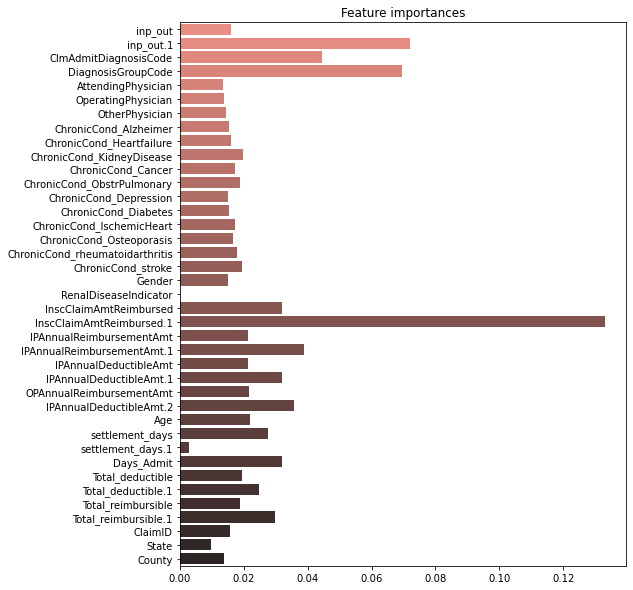

In [77]:
features=X_train.columns
coef = pd.Series(r_cfl.feature_importances_,features).sort_values()
plt.figure(figsize=(8,10))
plt.title('Feature importances')
sns.barplot(x=r_cfl.feature_importances_,y=features,palette='dark:salmon_r')
plt.show()

In [78]:
#dropping less important features
coef=coef[coef<0.005].index
X_train.drop(coef,axis=1,inplace=True)
X_test.drop(coef,axis=1,inplace=True)

In [79]:

r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

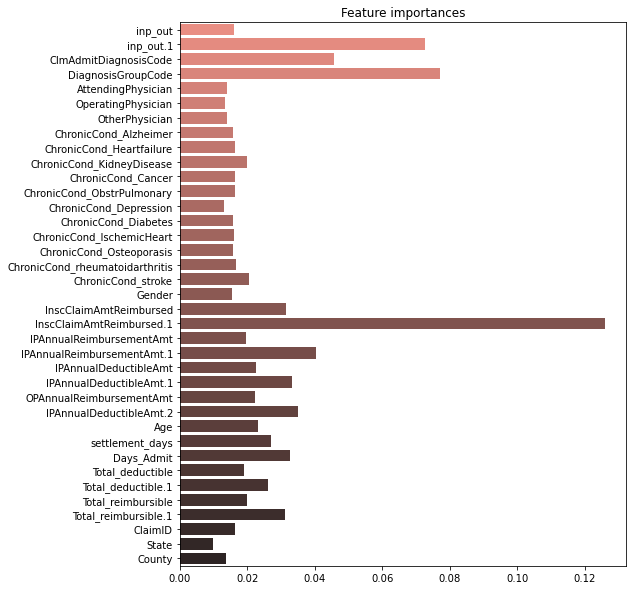

In [80]:
features=X_train.columns
coef = pd.Series(r_cfl.feature_importances_,features).sort_values()
plt.figure(figsize=(8,10))
plt.title('Feature importances')
sns.barplot(x=r_cfl.feature_importances_,y=features,palette='dark:salmon_r')
plt.show()

Creating functions 


In [81]:
def create_model(X_train, y_train, X_test, classifier):
    """Function that takes in the data, creates the model using the classifier, and performs prediction"""
    # Instantiate the model
    model = classifier 
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    return model, y_pred

In [82]:
#function for evaluation metrics 
def evaluation(y_test, y_pred):
    """
    A function to print evaluation metrics and classification report of a model
    """
    auc = roc_auc_score(y_test, y_pred)
    print(f"The model has an AUC score of {auc:.2%}")
    print("-----------------------------------------------")
    print(f"The model's recall rate is {recall_score(y_test, y_pred, average='weighted'):.2%}")
    print("-----------------------------------------------")
    print(f"The model's precision is {precision_score(y_test, y_pred, average='weighted'):.2%}")
    print("-----------------------------------------------")
    print(f"The model's F1 score is {f1_score(y_test, y_pred, average='weighted'):.2%}")
    print("-----------------------------------------------")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [83]:
def display_confusion_matrix(y_test, y_pred, cmap='GnBu'):
    """Display confusion matrix"""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['not_fraud', 'fraud'],
           yticklabels=['not_fraud', 'fraud'],
           xlabel='Predicted label',
           ylabel='True label',
           title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.4g'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "darkblue")
    ax.grid(False)
    fig.tight_layout()
    plt.show()

In [84]:
def plot_roc_curve(model, X_test, y_test):
    """Plot ROC curve for a binary classification model"""
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]  # Use predict_proba if available
    else:
        y_score = model.decision_function(X_test)  # Use decision_function as an alternative
    
    # Calculate False Positive Rate (FPR) and True Positive Rate (TPR) using roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [85]:
model, y_pred = create_model(X_train, y_train, X_test, classifier=KNeighborsClassifier())
evaluation(y_test, y_pred)

The model has an AUC score of 68.50%
-----------------------------------------------
The model's recall rate is 92.24%
-----------------------------------------------
The model's precision is 91.16%
-----------------------------------------------
The model's F1 score is 91.29%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       977
           1       0.67      0.39      0.49       105

    accuracy                           0.92      1082
   macro avg       0.80      0.69      0.73      1082
weighted avg       0.91      0.92      0.91      1082



# 1. `Baseline Model`

### Building a random model

In [86]:


train_data_len = X_train.shape[0]

op_list = [0, 1]

train_predicted_y = np.zeros(train_data_len)
for i in range(train_data_len):
    train_predicted_y[i] = random.choice(op_list)

train_accuracy = np.mean(train_predicted_y == y_train)
train_f1_score = f1_score(y_train, train_predicted_y)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Training F1 Score: {:.2f}%".format(train_f1_score*100))

test_data_len = X_test.shape[0]
test_predicted_y = np.zeros(test_data_len)
for i in range(test_data_len):
    test_predicted_y[i] = random.choice(op_list)

test_accuracy = np.mean(test_predicted_y == y_test)
test_f1_score = f1_score(y_test, test_predicted_y)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test F1 Score: {:.2f}%".format(test_f1_score*100))

Training Accuracy: 49.31%
Training F1 Score: 14.63%
Test Accuracy: 49.54%
Test F1 Score: 15.48%


### `Checking and Handling Class Imbalance`

#### Sampling Techniques 

- Undersampling technique

- oversampling technique

- Hybrid sampling technique

In [17]:
# undersampling technique
from imblearn.under_sampling import NearMiss
from collections import Counter

# Create an instance of NearMiss with a sampling ratio of 0.8
ns = NearMiss(sampling_strategy=0.8)

# Apply undersampling to the training data
x_train_ns, y_train_ns = ns.fit_resample(X_train, y_train)

# Print the class distribution before and after undersampling
print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_ns)))


The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 501, 1: 401})


`Decision Tree with undersampling`

In [18]:
model, y_pred = create_model(x_train_ns, y_train_ns, X_test, classifier=DecisionTreeClassifier(random_state=42))


In [19]:
evaluation(y_test, y_pred)

The model has an AUC score of 66.96%
-----------------------------------------------
The model's recall rate is 49.54%
-----------------------------------------------
The model's precision is 89.35%
-----------------------------------------------
The model's F1 score is 58.33%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.45      0.62       977
           1       0.15      0.89      0.25       105

    accuracy                           0.50      1082
   macro avg       0.56      0.67      0.44      1082
weighted avg       0.89      0.50      0.58      1082



`Random Forest with undersampling`

In [20]:
model, y_pred = create_model(x_train_ns, y_train_ns, X_test, classifier=RandomForestClassifier(random_state=42))


In [21]:
evaluation(y_test, y_pred)

The model has an AUC score of 69.57%
-----------------------------------------------
The model's recall rate is 54.25%
-----------------------------------------------
The model's precision is 89.72%
-----------------------------------------------
The model's F1 score is 62.81%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.51      0.67       977
           1       0.16      0.89      0.27       105

    accuracy                           0.54      1082
   macro avg       0.57      0.70      0.47      1082
weighted avg       0.90      0.54      0.63      1082



In [22]:
# oversampling technique

from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# Assuming X_train and y_train are defined and assigned values correctly

os = RandomOverSampler(sampling_strategy=0.75)
x_train_os, y_train_os = os.fit_resample(X_train, y_train)

print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_os)))


The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 3927, 1: 2945})


`Decision tree with oversampling technique`

In [23]:
model, y_pred = create_model(x_train_os, y_train_os, X_test, classifier=DecisionTreeClassifier(random_state=42))


In [24]:
evaluation(y_test, y_pred)

The model has an AUC score of 71.10%
-----------------------------------------------
The model's recall rate is 90.02%
-----------------------------------------------
The model's precision is 89.93%
-----------------------------------------------
The model's F1 score is 89.98%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       977
           1       0.49      0.48      0.48       105

    accuracy                           0.90      1082
   macro avg       0.71      0.71      0.71      1082
weighted avg       0.90      0.90      0.90      1082



`random forest with over sampling technique`

In [25]:
model, y_pred = create_model(x_train_os, y_train_os, X_test, classifier=RandomForestClassifier(random_state=42))


In [26]:
evaluation(y_test, y_pred)

The model has an AUC score of 73.87%
-----------------------------------------------
The model's recall rate is 91.96%
-----------------------------------------------
The model's precision is 91.48%
-----------------------------------------------
The model's F1 score is 91.68%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       977
           1       0.60      0.51      0.55       105

    accuracy                           0.92      1082
   macro avg       0.77      0.74      0.75      1082
weighted avg       0.91      0.92      0.92      1082



`Hybrid sampling technique`

In [27]:
st = SMOTETomek()
x_train_st, y_train_st = st.fit_resample(X_train, y_train)

print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_st)))

The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 3863, 1: 3863})


`Decision tree Hybrid sampling technique`

In [28]:
model, y_pred = create_model(x_train_st, y_train_st, X_test, classifier=DecisionTreeClassifier(random_state=42))


In [29]:
evaluation(y_test, y_pred)

The model has an AUC score of 72.50%
-----------------------------------------------
The model's recall rate is 86.41%
-----------------------------------------------
The model's precision is 89.27%
-----------------------------------------------
The model's F1 score is 87.59%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       977
           1       0.37      0.55      0.44       105

    accuracy                           0.86      1082
   macro avg       0.66      0.73      0.68      1082
weighted avg       0.89      0.86      0.88      1082



`Random Forest hybrid sampling technique`

In [30]:
model, y_pred = create_model(x_train_st, y_train_st, X_test, classifier=RandomForestClassifier(random_state=42))


In [31]:
evaluation(y_test, y_pred)

The model has an AUC score of 79.96%
-----------------------------------------------
The model's recall rate is 90.67%
-----------------------------------------------
The model's precision is 91.95%
-----------------------------------------------
The model's F1 score is 91.19%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       977
           1       0.51      0.67      0.58       105

    accuracy                           0.91      1082
   macro avg       0.74      0.80      0.76      1082
weighted avg       0.92      0.91      0.91      1082



Scaling the Numerical Features 


In [32]:
from sklearn.preprocessing import StandardScaler

# Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(x_train_st)
X_test_scaled = scaler.transform(X_test)

## 2. `KNN Model`

In [33]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=KNeighborsClassifier())
evaluation(y_test, y_pred)

The model has an AUC score of 80.73%
-----------------------------------------------
The model's recall rate is 84.38%
-----------------------------------------------
The model's precision is 91.13%
-----------------------------------------------
The model's F1 score is 86.70%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       977
           1       0.36      0.76      0.49       105

    accuracy                           0.84      1082
   macro avg       0.66      0.81      0.70      1082
weighted avg       0.91      0.84      0.87      1082



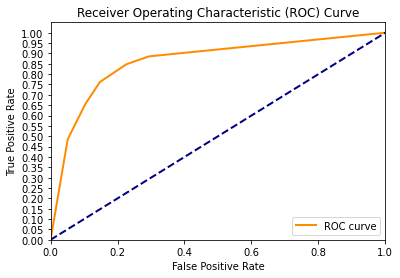

In [34]:

plot_roc_curve(model, X_test_scaled, y_test)

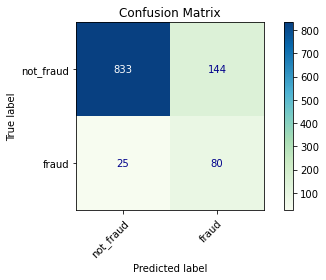

In [35]:

display_confusion_matrix(y_test, y_pred)

## 3. `Decision Trees Model`

In [36]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=DecisionTreeClassifier(random_state=42))

evaluation(y_test, y_pred)

The model has an AUC score of 72.50%
-----------------------------------------------
The model's recall rate is 86.41%
-----------------------------------------------
The model's precision is 89.27%
-----------------------------------------------
The model's F1 score is 87.59%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       977
           1       0.37      0.55      0.44       105

    accuracy                           0.86      1082
   macro avg       0.66      0.73      0.68      1082
weighted avg       0.89      0.86      0.88      1082



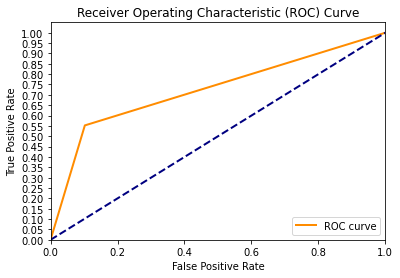

In [37]:

plot_roc_curve(model, X_test_scaled, y_test)

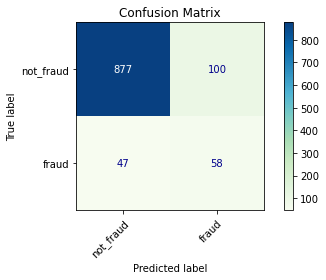

In [38]:

display_confusion_matrix(y_test, y_pred)

## 4. `SVM`

In [39]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=SVC(random_state=42))
evaluation(y_test, y_pred)

The model has an AUC score of 84.28%
-----------------------------------------------
The model's recall rate is 86.97%
-----------------------------------------------
The model's precision is 92.24%
-----------------------------------------------
The model's F1 score is 88.73%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.92       977
           1       0.41      0.81      0.55       105

    accuracy                           0.87      1082
   macro avg       0.69      0.84      0.74      1082
weighted avg       0.92      0.87      0.89      1082



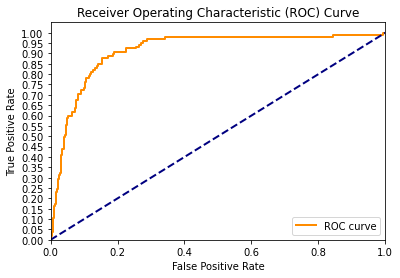

In [40]:
plot_roc_curve(model, X_test_scaled, y_test)

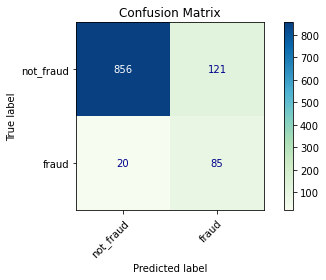

In [41]:
display_confusion_matrix(y_test, y_pred)

## 5. `Gradientboost model`

In [42]:

model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=GradientBoostingClassifier(random_state=42))
evaluation(y_test, y_pred)

The model has an AUC score of 83.54%
-----------------------------------------------
The model's recall rate is 87.15%
-----------------------------------------------
The model's precision is 92.07%
-----------------------------------------------
The model's F1 score is 88.83%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       977
           1       0.41      0.79      0.54       105

    accuracy                           0.87      1082
   macro avg       0.70      0.84      0.73      1082
weighted avg       0.92      0.87      0.89      1082



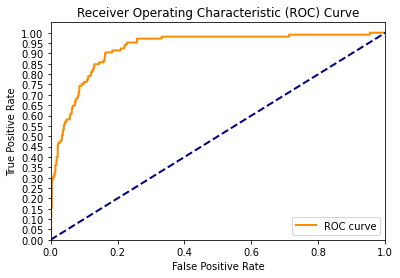

In [43]:

plot_roc_curve(model, X_test_scaled, y_test)

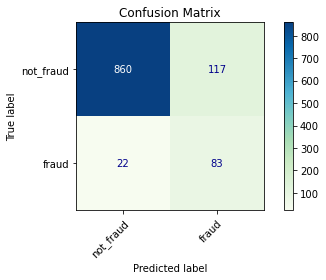

In [44]:

display_confusion_matrix(y_test, y_pred)

## 5. `Logistic regression Model`

In [45]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=LogisticRegression(random_state=42))
evaluation(y_test, y_pred)

The model has an AUC score of 83.88%
-----------------------------------------------
The model's recall rate is 88.54%
-----------------------------------------------
The model's precision is 92.33%
-----------------------------------------------
The model's F1 score is 89.85%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       977
           1       0.45      0.78      0.57       105

    accuracy                           0.89      1082
   macro avg       0.71      0.84      0.75      1082
weighted avg       0.92      0.89      0.90      1082



c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


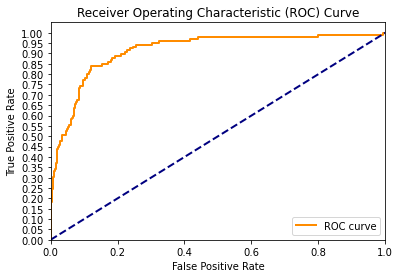

In [46]:
plot_roc_curve(model, X_test_scaled, y_test)


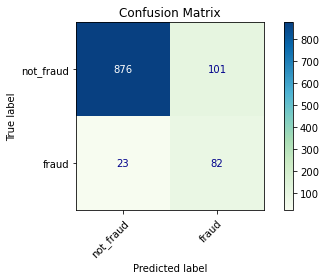

In [47]:
display_confusion_matrix(y_test, y_pred)

## 6. `XGBoost`

In [48]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=XGBClassifier(random_state=42))

In [49]:
evaluation(y_test, y_pred)

The model has an AUC score of 75.74%
-----------------------------------------------
The model's recall rate is 89.19%
-----------------------------------------------
The model's precision is 90.62%
-----------------------------------------------
The model's F1 score is 89.79%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       977
           1       0.46      0.59      0.51       105

    accuracy                           0.89      1082
   macro avg       0.71      0.76      0.73      1082
weighted avg       0.91      0.89      0.90      1082



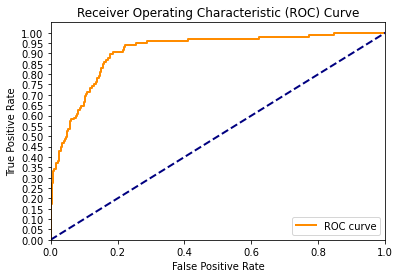

In [50]:
plot_roc_curve(model, X_test_scaled, y_test)

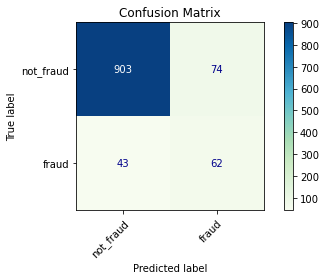

In [51]:
display_confusion_matrix(y_test, y_pred)

hypertuning 

In [100]:
class XGBoostModel:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.best_estimator = None
    
    def train_best_estimator(self, X_train, y_train):
        self.best_estimator = XGBClassifier(subsample=1, n_estimators=100, max_depth=3, colsample_bytree=1, learning_rate=0.1, random_state=self.random_state)
        self.best_estimator.fit(X_train, y_train)
    
    def evaluate_best_estimator(self, X_test, y_test):
        train_y_pred_binary = (train_y_pred >= 0.5).astype(int)
          # Calculate evaluation metrics
        auc = roc_auc_score(y_train_st, train_y_pred)
        recall = recall_score(y_train_st, train_y_pred_binary, average='weighted')
        precision = precision_score(y_train_st, train_y_pred_binary, average='weighted')
        f1 = f1_score(y_train_st, train_y_pred_binary, average='weighted')

         # Print evaluation metrics
        print(f"The model has an AUC score of {auc:.2%}")
        print("-----------------------------------------------")
        print(f"The model's recall rate is {recall:.2%}")
        print("-----------------------------------------------")
        print(f"The model's precision is {precision:.2%}")
        print("-----------------------------------------------")
        print(f"The model's F1 score is {f1:.2%}")
        print("-----------------------------------------------")

        # Print classification report
        print("Classification Report:")
        print(classification_report(y_train_st, train_y_pred_binary))
    
    def display_confusion_matrix(self, X_test, y_test):
        y_pred = self.best_estimator.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.matshow(cm, cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.xticks([0, 1], ['Negative', 'Positive'])
        plt.yticks([0, 1], ['Negative', 'Positive'])
        plt.title('Confusion matrix')
        plt.show()

    def evaluate_overfitting(self, X_train, y_train, X_test, y_test):
        train_pred = self.best_estimator.predict(X_train)
        test_pred = self.best_estimator.predict(X_test)

        train_f1 = f1_score(y_train, train_pred)
        test_f1 = f1_score(y_test, test_pred)

        print("Train set F1 score:", train_f1)
        print("Test set F1 score:", test_f1)

In [101]:
# Instantiate the XGBoostModel class
model = XGBoostModel(random_state=42)

# Train the model
model.train_best_estimator(X_train_scaled, y_train_st)


In [102]:
# Evaluate the model
model.evaluate_best_estimator(X_test_scaled, y_test)

The model has an AUC score of 97.88%
-----------------------------------------------
The model's recall rate is 92.79%
-----------------------------------------------
The model's precision is 92.94%
-----------------------------------------------
The model's F1 score is 92.78%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      3863
           1       0.90      0.96      0.93      3863

    accuracy                           0.93      7726
   macro avg       0.93      0.93      0.93      7726
weighted avg       0.93      0.93      0.93      7726



In [103]:
model.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)

Train set F1 score: 0.9299811439346324
Test set F1 score: 0.535483870967742


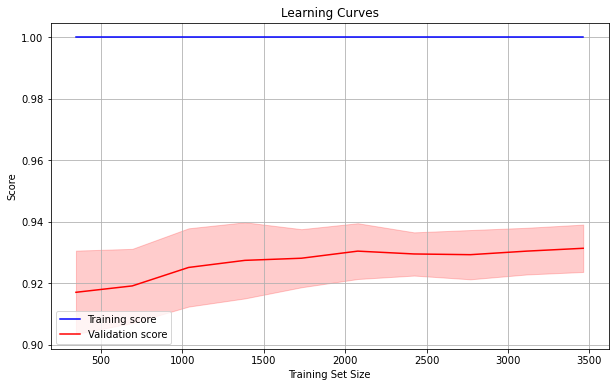

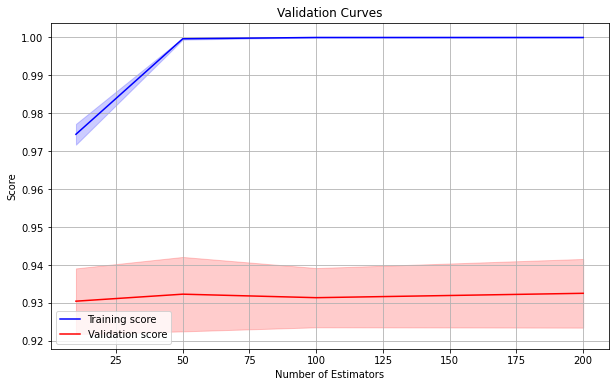

In [104]:
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve, validation_curve
import numpy as np
import matplotlib.pyplot as plt

# Instantiate the RandomForestClassifier model
model = XGBClassifier()

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of training scores and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, val_mean, label='Validation score', color='red')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Generate validation curves
param_range = [10, 50, 100, 200]  # Example hyperparameter values to vary
train_scores, val_scores = validation_curve(model, X_train, y_train, param_name='n_estimators', param_range=param_range, cv=5)

# Calculate mean and standard deviation of training scores and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot validation curves
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training score', color='blue')
plt.plot(param_range, val_mean, label='Validation score', color='red')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Validation Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## 7. `Random Forest Model`

In [55]:

model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=RandomForestClassifier(random_state=42))
evaluation(y_test, y_pred)

The model has an AUC score of 79.96%
-----------------------------------------------
The model's recall rate is 90.67%
-----------------------------------------------
The model's precision is 91.95%
-----------------------------------------------
The model's F1 score is 91.19%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       977
           1       0.51      0.67      0.58       105

    accuracy                           0.91      1082
   macro avg       0.74      0.80      0.76      1082
weighted avg       0.92      0.91      0.91      1082



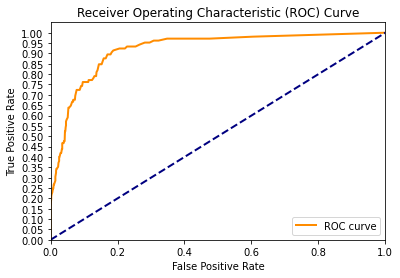

In [56]:
plot_roc_curve(model, X_test_scaled, y_test)


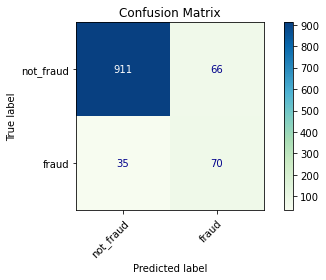

In [57]:
display_confusion_matrix(y_test, y_pred)

`hyper tuning `